In [ ]:
#import necessary libraries
import os, cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import GlobalAveragePooling2D, Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D, Flatten, Input,Conv2DTranspose,concatenate
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import tensorflow as tf
from keras.metrics import Precision, Recall


In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 5.2 MB/s 


In [ ]:
import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing

Segmentation Models: using `keras` framework.
1.0.1


In [ ]:
!nvidia-smi

Fri Nov 12 12:12:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#read training data
train_path = '/content/drive/MyDrive/ML Project/train_images'
train_image_names = os.listdir(train_path)
train_label = pd.read_csv('/content/drive/MyDrive/ML Project/train.csv')
train_label

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [ ]:
#create a data frame of with column image id and class id to perform join operation on given train.csv
tr_img_id = []
tr_cls_id = []
for i in train_image_names:
  tr_img_id.append(i)
  tr_cls_id.append(1)
  tr_img_id.append(i)
  tr_cls_id.append(2)
  tr_img_id.append(i)
  tr_cls_id.append(3)
  tr_img_id.append(i)
  tr_cls_id.append(4)

In [ ]:
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms

,ImageId,ClassId
0,eb27105ee.jpg,1
1,eb27105ee.jpg,2
2,eb27105ee.jpg,3
3,eb27105ee.jpg,4
4,eb0969906.jpg,1
...,...,...
50467,09d87038e.jpg,4
50468,0a26aceb2.jpg,1
50469,0a26aceb2.jpg,2
50470,0a26aceb2.jpg,3


In [ ]:
#perform outer join on dataframe and train_label df on ImageId and ClassId
train_df = pd.merge(train_img_nms, train_label,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df

,ImageId,ClassId,EncodedPixels
0,eb27105ee.jpg,1,
1,eb27105ee.jpg,2,
2,eb27105ee.jpg,3,
3,eb27105ee.jpg,4,
4,eb0969906.jpg,1,
...,...,...,...
50467,09d87038e.jpg,4,
50468,0a26aceb2.jpg,1,
50469,0a26aceb2.jpg,2,
50470,0a26aceb2.jpg,3,19347 4 19595 12 19843 20 20091 28 20339 36 20...


In [ ]:
#manipulate dataframe
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,
...,...,...,...,...,...
12613,fff0295e1.jpg,,,,
12614,fff02e9c5.jpg,,,207523 3 207777 9 208030 15 208283 22 208537 2...,
12615,fffe98443.jpg,,,105929 5 106177 14 106424 24 106672 33 106923 ...,
12616,ffff4eaa8.jpg,,,16899 7 17155 20 17411 34 17667 47 17923 60 18...,


In [ ]:
tmp = []
for i in range(len(train_data)):
  if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_1'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_2'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_3'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_3'] = tmp
  
tmp = []
for i in range(len(train_data)):
  if train_data['Defect_4'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
12613,fff0295e1.jpg,,,,,0,0,0,0,0
12614,fff02e9c5.jpg,,,207523 3 207777 9 208030 15 208283 22 208537 2...,,1,0,0,1,0
12615,fffe98443.jpg,,,105929 5 106177 14 106424 24 106672 33 106923 ...,,1,0,0,1,0
12616,ffff4eaa8.jpg,,,16899 7 17155 20 17411 34 17667 47 17923 60 18...,,1,0,0,1,0


In [ ]:
#data preparation
tmp = []
for i in range(len(train_data)):
  if train_data['hasDefect_2'].iloc[i]==1:
    tmp.append(2)
  elif train_data['hasDefect_4'].iloc[i]==1:
    tmp.append(4)
  elif train_data['hasDefect_1'].iloc[i]==1:
    tmp.append(1)
  elif train_data['hasDefect_3'].iloc[i]==1:
    tmp.append(3)
  else:
    tmp.append(0)
train_data['stratify']=tmp

X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
X_train = X_train.drop(['stratify'], axis = 1)
X_val = X_val.drop(['stratify'], axis = 1)
X_test = X_test.drop(['stratify'], axis = 1)
print(X_train.shape, X_val.shape, X_test.shape)

(9084, 10) (2272, 10) (1262, 10)


In [ ]:
# Dividing the datasets w.r.t. Class Label (defect type)
train_data_1 = X_train[X_train['hasDefect_1']==1][['ImageId','Defect_1']]
train_data_2 = X_train[X_train['hasDefect_2']==1][['ImageId','Defect_2']]
train_data_3 = X_train[X_train['hasDefect_3']==1][['ImageId','Defect_3']]
train_data_4 = X_train[X_train['hasDefect_4']==1][['ImageId','Defect_4']]

val_data_1 = X_val[X_val['hasDefect_1']==1][['ImageId','Defect_1']]
val_data_2 = X_val[X_val['hasDefect_2']==1][['ImageId','Defect_2']]
val_data_3 = X_val[X_val['hasDefect_3']==1][['ImageId','Defect_3']]
val_data_4 = X_val[X_val['hasDefect_4']==1][['ImageId','Defect_4']]

test_data_1 = X_test[X_test['hasDefect_1']==1][['ImageId','Defect_1']]
test_data_2 = X_test[X_test['hasDefect_2']==1][['ImageId','Defect_2']]
test_data_3 = X_test[X_test['hasDefect_3']==1][['ImageId','Defect_3']]
test_data_4 = X_test[X_test['hasDefect_4']==1][['ImageId','Defect_4']]

train_data_1.columns = train_data_2.columns = train_data_3.columns = train_data_4.columns = ['ImageId','EncodedPixels']
val_data_1.columns = val_data_2.columns = val_data_3.columns = val_data_4.columns = ['ImageId','EncodedPixels']
test_data_1.columns = test_data_2.columns = test_data_3.columns = test_data_4.columns = ['ImageId','EncodedPixels']

print(test_data_1.head())
print('-'*50)
print(X_train.shape, X_val.shape, X_test.shape)
print(train_data_1.shape,val_data_1.shape,test_data_1.shape)
print(train_data_2.shape,val_data_2.shape,test_data_2.shape)
print(train_data_3.shape,val_data_3.shape,test_data_3.shape)
print(train_data_4.shape,val_data_4.shape,test_data_4.shape)

            ImageId                                      EncodedPixels
78    017c828a1.jpg  246414 3 246557 29 246665 9 246800 54 246916 1...
8547  ac7b3fdd1.jpg  366093 3 366345 9 366516 6 366597 14 366768 14...
5682  72bebf035.jpg  36937 21 37172 42 37428 42 37684 42 37940 42 3...
8174  a53891ed0.jpg  225989 11 226140 17 226227 33 226295 10 226384...
1363  1b88aba1a.jpg  336347 12 336601 14 336855 16 337110 17 337365...
--------------------------------------------------
(9084, 10) (2272, 10) (1262, 10)
(648, 2) (160, 2) (89, 2)
(178, 2) (44, 2) (25, 2)
(3695, 2) (927, 2) (528, 2)
(577, 2) (144, 2) (80, 2)


In [ ]:
def rle2maskResize(encoded_pixels):
  s = encoded_pixels.split(' ')
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  img = np.zeros(1600*256, dtype=np.float32)
  for lo, hi in zip(starts, ends):
    img[lo:hi] = 1
  mask = np.reshape(img, (1600,256)).T
  mask_resized = cv2.resize(mask, (800,256))
  return mask_resized
  
def rle2mask(encoded_pixels):
  s = encoded_pixels.split(' ')
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  img = np.zeros(1600*256, dtype=np.float32)
  for lo, hi in zip(starts, ends):
    img[lo:hi] = 1
  return img.reshape(1600,256).T
  

In [ ]:
class train_DataGenerator_3(tf.keras.utils.Sequence): # with augmentation for training


    def __init__(self, df, batch_size = 8,  shuffle=True, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/ML Project/train_images//'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        X1 = np.empty((self.batch_size,256,800,3),dtype=np.float32)

        y = np.empty((self.batch_size,256,800,1),dtype=np.float32)
        y1 = np.empty((self.batch_size,256,800,1),dtype=np.float32)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))           
            y[i,:,:,0] = rle2maskResize(self.df['EncodedPixels'].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)

        # generate some random image augmentations
        augment = np.random.random()
        if augment>0.35:
            in_gen1 = ImageDataGenerator()
            augment1 = np.random.random()
            augment2 = np.random.random()
            augment3 = np.random.random()
            augment4 = np.random.random()
            augment5 = np.random.random()
            augment6 = np.random.random()

            args = dict(tx = 0, ty = 0, zx = 1.0, zy= 1.0, flip_horizontal = False, flip_vertical = False)

            if augment1>0.5:
                args.update({'tx':50})

            if augment2>0.5:
                args.update({'ty':25})

            if augment3>0.5:
                args.update({'zx':0.9})

            if augment4>0.5:
                args.update({'zy':0.9})

            if augment5>0.5:
                args.update({'flip_horizontal' : True})

            if augment6>0.5:
                args.update({'flip_vertical' : True})

            for i,h in enumerate(X):
                X1[i] = in_gen1.apply_transform(h, transform_parameters = args)
            for i,g in enumerate(y):
                y1[i] = in_gen1.apply_transform(g, transform_parameters = args)
            return X1, y1
        else:
            return X, y

In [ ]:
class test_DataGenerator_3(tf.keras.utils.Sequence): # without augmentations for predictions
  
    def __init__(self, df, batch_size = 1, shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/ML Project/train_images//'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,256,800,1),dtype=np.float32)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))      
            y[i,:,:,0] = rle2maskResize(self.df['EncodedPixels'].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

In [ ]:
import segmentation_models as sm
from keras import backend as K
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
preprocess = get_preprocessing('vgg16') 
model = Unet('vgg16', classes=1, activation='sigmoid', encoder_weights='imagenet') 
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

In [ ]:
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1-(numerator / (denominator + tf.keras.backend.epsilon()))

dependencies = {'dice_loss':dice_loss,
                'dice_coef':dice_coef}

In [ ]:
def plot_dice_metric(history):
  vy = history.history['val_dice_coef']
  ty = history.history['dice_coef']
  x = list(range(1,len(vy)+1))
  fig,ax = plt.subplots(1,1)
  ax.plot(x,vy,'r',label = "Validation dice")
  ax.plot(x,ty,'b',label = "Train dice")
  ax.set_xlabel('epoch')
  ax.set_ylabel('Metric: dice coef')
  plt.legend()
  plt.grid()
  plt.show()

def model_evaluation(model,data):
  evaluation = model.evaluate(test_DataGenerator_3(data),verbose=1)
  print(pd.DataFrame(evaluation, columns = [' '], index=['dice_loss','dice_coef']))

Defect 1

In [ ]:

model.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_1, batch_size=4,shuffle=True, preprocess=preprocess)    
valid_batches = test_DataGenerator_3(val_data_1, preprocess=preprocess)
    
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_1_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1_transfer.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)

#model training
history = model.fit(train_batches, validation_data = valid_batches, epochs = 5, verbose=1, callbacks = [mc])

Epoch 1/5
162/162 [==============================] - ETA: 0s - loss: 0.7056 - dice_coef: 0.2944
Epoch 00001: val_dice_coef improved from -inf to 0.37857, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1_transfer.h5
162/162 [==============================] - 217s 1s/step - loss: 0.7056 - dice_coef: 0.2944 - val_loss: 0.6214 - val_dice_coef: 0.3786
Epoch 2/5
162/162 [==============================] - ETA: 0s - loss: 0.5073 - dice_coef: 0.4927
Epoch 00002: val_dice_coef improved from 0.37857 to 0.54100, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1_transfer.h5
162/162 [==============================] - 215s 1s/step - loss: 0.5073 - dice_coef: 0.4927 - val_loss: 0.4590 - val_dice_coef: 0.5410
Epoch 3/5
162/162 [==============================] - ETA: 0s - loss: 0.4726 - dice_coef: 0.5274
Epoch 00003: val_dice_coef did not improve from 0.54100
162/162 [==============================] - 211s 1s/step - los

In [ ]:
model_segm1 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_1_transfer.h5',custom_objects=dependencies)
plot_dice_metric(history)
print('Train set evaluation score:')
model_evaluation(model_segm1,train_data_1)
print('Validation set evaluation score:')
model_evaluation(model_segm1,val_data_1)
print('Test set evaluation score:')
model_evaluation(model_segm1,test_data_1)

10/10 [==============================] - 1s 157ms/step


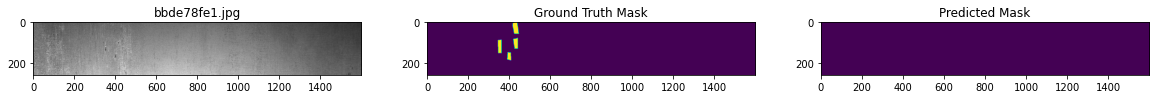

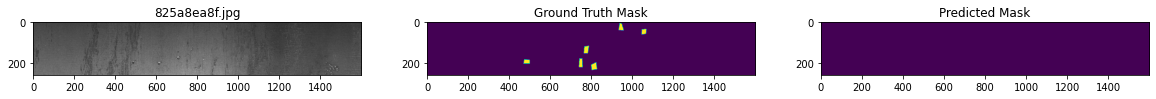

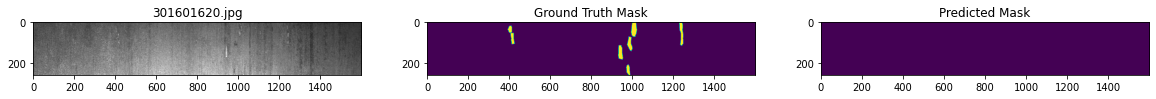

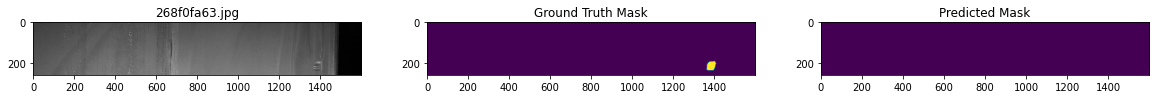

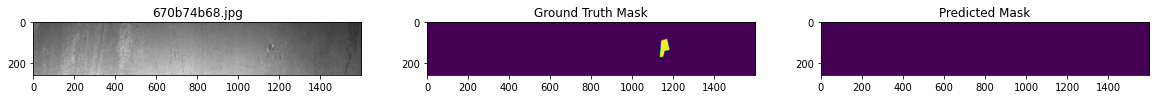

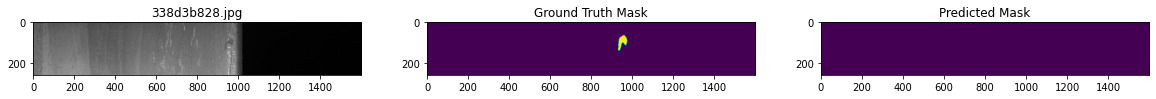

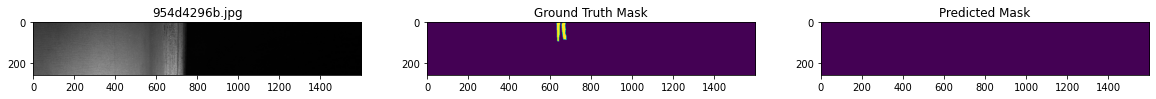

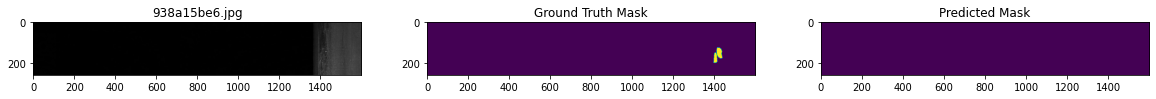

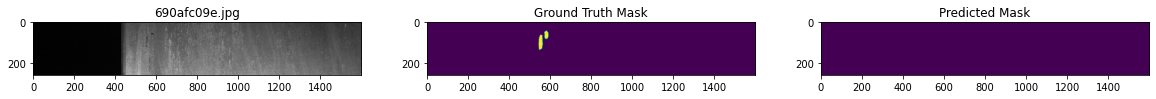

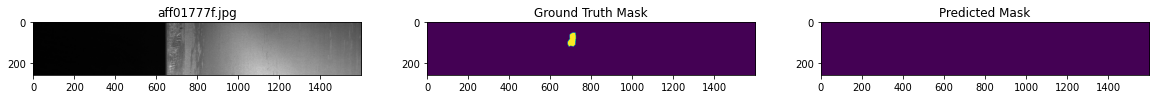

In [ ]:
# Train dataset prediction visualization
test_preds = model_segm1.predict(test_DataGenerator_3(test_data_1[10:20]),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 10))
    img = cv2.imread(str('/content/drive/MyDrive/ML Project/train_images//' + test_data_1[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_1[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_1[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

Defect -2 

In [ ]:
model.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_2, batch_size=4,shuffle=True, preprocess=preprocess)    
valid_batches = test_DataGenerator_3(val_data_2, preprocess=preprocess)
    
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_2_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2_transfer.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)

#model training
history = model.fit(train_batches, validation_data = valid_batches, epochs = 5, verbose=1, callbacks = [mc])

Epoch 1/5
44/44 [==============================] - ETA: 0s - loss: 0.6337 - dice_coef: 0.3663
Epoch 00001: val_dice_coef improved from -inf to 0.37218, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2_transfer.h5
44/44 [==============================] - 69s 1s/step - loss: 0.6337 - dice_coef: 0.3663 - val_loss: 0.6278 - val_dice_coef: 0.3722
Epoch 2/5
44/44 [==============================] - ETA: 0s - loss: 0.4735 - dice_coef: 0.5265
Epoch 00002: val_dice_coef improved from 0.37218 to 0.58196, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2_transfer.h5
44/44 [==============================] - 61s 1s/step - loss: 0.4735 - dice_coef: 0.5265 - val_loss: 0.4180 - val_dice_coef: 0.5820
Epoch 3/5
44/44 [==============================] - ETA: 0s - loss: 0.4688 - dice_coef: 0.5312
Epoch 00003: val_dice_coef did not improve from 0.58196
44/44 [==============================] - 58s 1s/step - loss: 0.4688 - dic

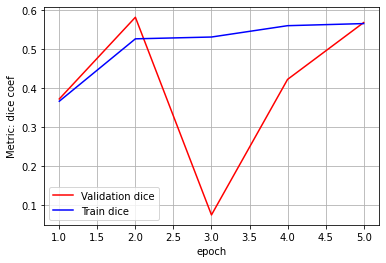

Train set evaluation score:
178/178 [==============================] - 27s 148ms/step - loss: 0.7978 - dice_coef: 0.2022
                  
dice_loss  0.79785
dice_coef  0.20215
Validation set evaluation score:
44/44 [==============================] - 7s 147ms/step - loss: 0.8126 - dice_coef: 0.1874
                   
dice_loss  0.812589
dice_coef  0.187411
Test set evaluation score:
25/25 [==============================] - 7s 264ms/step - loss: 0.7967 - dice_coef: 0.2033
                   
dice_loss  0.796671
dice_coef  0.203329


In [ ]:
model_segm2 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2_transfer.h5',custom_objects=dependencies)
plot_dice_metric(history)
print('Train set evaluation score:')
model_evaluation(model_segm2,train_data_2)
print('Validation set evaluation score:')
model_evaluation(model_segm2,val_data_2)
print('Test set evaluation score:')
model_evaluation(model_segm2,test_data_2)

10/10 [==============================] - 2s 159ms/step


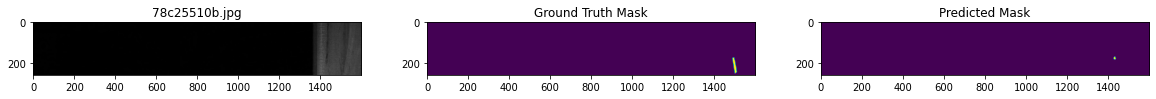

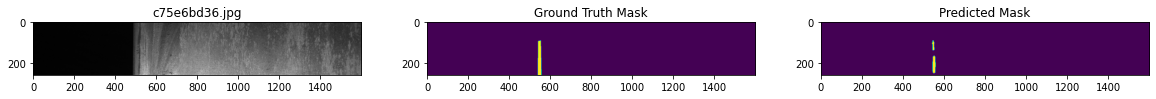

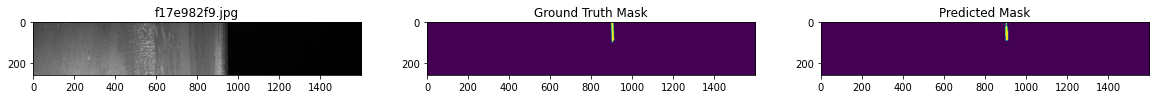

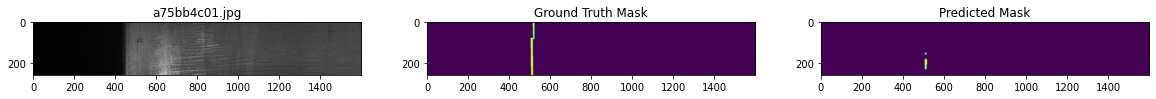

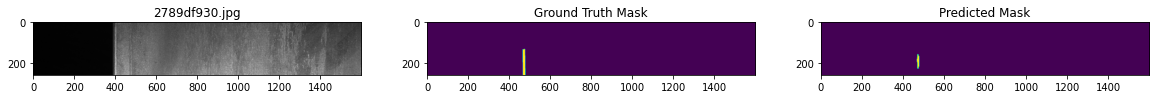

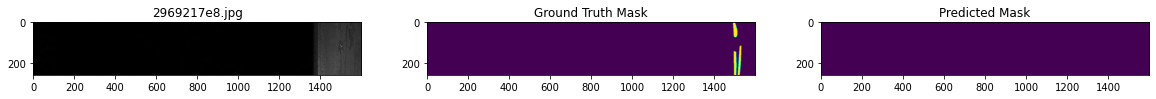

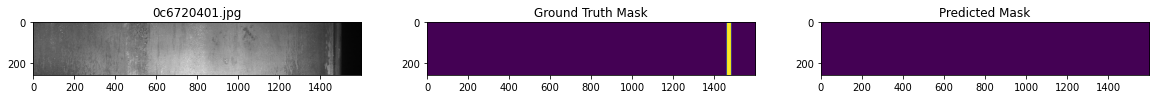

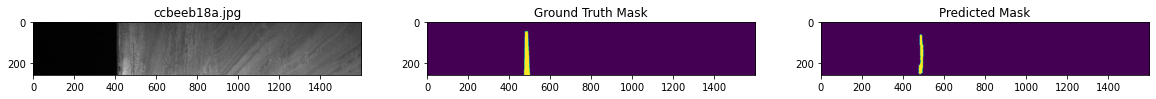

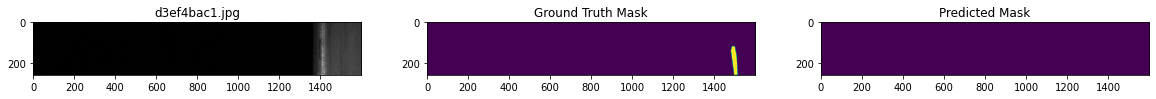

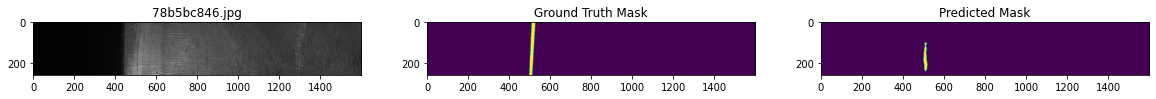

In [ ]:
model_segm2 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_2_transfer.h5',custom_objects=dependencies)
test_preds = model_segm2.predict(test_DataGenerator_3(test_data_2[10:20]),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 10))
    img = cv2.imread(str('/content/drive/MyDrive/ML Project/train_images//' + test_data_2[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_2[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_2[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

Defect-3

In [ ]:
model.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_3, batch_size = 16,shuffle=True, preprocess=preprocess)    
valid_batches = test_DataGenerator_3(val_data_3, preprocess=preprocess)
    
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_3_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3_transfer.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)

#model training
history = model.fit(train_batches, validation_data = valid_batches, epochs = 5, verbose=1, callbacks = [mc])

Epoch 1/5
230/230 [==============================] - ETA: 0s - loss: 0.4408 - dice_coef: 0.5592
Epoch 00001: val_dice_coef improved from -inf to 0.53507, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3_transfer.h5
230/230 [==============================] - 1304s 5s/step - loss: 0.4408 - dice_coef: 0.5592 - val_loss: 0.4649 - val_dice_coef: 0.5351
Epoch 2/5
230/230 [==============================] - ETA: 0s - loss: 0.3794 - dice_coef: 0.6206
Epoch 00002: val_dice_coef improved from 0.53507 to 0.59174, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3_transfer.h5
230/230 [==============================] - 775s 3s/step - loss: 0.3794 - dice_coef: 0.6206 - val_loss: 0.4083 - val_dice_coef: 0.5917
Epoch 3/5
230/230 [==============================] - ETA: 0s - loss: 0.3681 - dice_coef: 0.6319
Epoch 00003: val_dice_coef did not improve from 0.59174
230/230 [==============================] - 772s 3s/step - lo

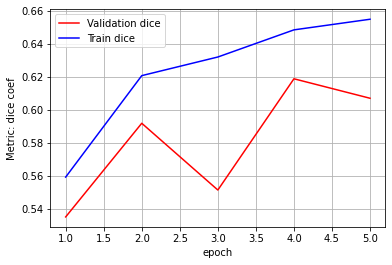

Train set evaluation score:
3695/3695 [==============================] - 548s 148ms/step - loss: 0.6494 - dice_coef: 0.3506
                   
dice_loss  0.649449
dice_coef  0.350550
Validation set evaluation score:
927/927 [==============================] - 138s 149ms/step - loss: 0.6574 - dice_coef: 0.3426
                   
dice_loss  0.657369
dice_coef  0.342631
Test set evaluation score:
528/528 [==============================] - 142s 269ms/step - loss: 0.6388 - dice_coef: 0.3612
                   
dice_loss  0.638767
dice_coef  0.361233


In [ ]:
model_segm3 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_3_transfer.h5',custom_objects=dependencies)
plot_dice_metric(history)
print('Train set evaluation score:')
model_evaluation(model_segm3,train_data_3)
print('Validation set evaluation score:')
model_evaluation(model_segm3,val_data_3)
print('Test set evaluation score:')
model_evaluation(model_segm3,test_data_3)

Defect-4

In [ ]:
model.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[dice_coef])
train_batches = train_DataGenerator_3(train_data_4, batch_size=4,shuffle=True, preprocess=preprocess)    
valid_batches = test_DataGenerator_3(val_data_4, preprocess=preprocess)
    
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_4_Segmentation'
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4_transfer.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)

#model training
history = model.fit(train_batches, validation_data = valid_batches, epochs = 5, verbose=1, callbacks = [mc])

In [ ]:
model_segm3 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Segmentation_Defect_4_transfer.h5',custom_objects=dependencies)
plot_dice_metric(history)
print('Train set evaluation score:')
model_evaluation(model_segm4,train_data_4)
print('Validation set evaluation score:')
model_evaluation(model_segm4,val_data_4)
print('Test set evaluation score:')
model_evaluation(model_segm4,test_data_4)